<a href="https://colab.research.google.com/github/cedricfoucault/scarletbutterfly/blob/master/scarletbutterfly_decoding_steinmetz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
#@title matplotlib settings
import matplotlib.pyplot as plt
from matplotlib import rcParams 

rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Loading of Steinmetz data

In [4]:
#@title Data retrieval
import os, requests
fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [5]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

n_sessions = len(alldat)
print("n_sessions", n_sessions)

n_sessions 39


In [6]:
print(list(alldat[0].keys()))

['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive']


In [7]:
#@title Filter Trial Data
import copy
filtered_data = copy.deepcopy(alldat)

bin_size = alldat[0]['bin_size']
stim_onset = alldat[0]['stim_onset']
for i in range(len(alldat)):
  assert bin_size == alldat[i]['bin_size'], "inconsistent bin size"
  assert stim_onset == alldat[i]['stim_onset'], "inconsistent stim onset"

# Filter only the keys we are going to use
# used_keys = ['spks', 'pupil', 'lfp', 'response', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'mouse_name']
used_keys = ['spks', 'pupil', 'response', 'contrast_right', 'contrast_left', 'brain_area', 'mouse_name', 'reaction_time']
for i_session in range(n_sessions):
  filtered_data[i_session] = { key: filtered_data[i_session][key] for key in used_keys }


# # Eliminate trials where contrast is > 0 and equal on both sides
for i_session in range(n_sessions):
  session_data = filtered_data[i_session]
  equal_contrast = session_data['contrast_right'] == session_data['contrast_left']
  positive_contrast_right = session_data['contrast_right'] > 0
  should_filter = equal_contrast & positive_contrast_right

  session_data['spks'] = session_data['spks'][:,~should_filter,:]
  session_data['pupil'] = session_data['pupil'][:,~should_filter,:]
  # session_data['lfp'] = session_data['lfp'][:,~should_filter,:]

  session_data['response'] = session_data['response'][~should_filter]
  session_data['contrast_right'] = session_data['contrast_right'][~should_filter]
  session_data['contrast_left'] = session_data['contrast_left'][~should_filter]
  session_data['reaction_time'] = session_data['reaction_time'][~should_filter]





In [8]:
#Extracting brain areas:
brain_areas = set()

for i in range(n_sessions):
  brain_areas.update(filtered_data[i]['brain_area'])


#Let's focus on subcortical brain areas as they appear to experience a spike 
#Basal ganglia, midbrain
basal_ganglia = ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"]
midbrain = ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"]

count_dict = {area:0 for area in brain_areas}

for i in range(n_sessions):
  for area in set(filtered_data[i]['brain_area']):
      count_dict[area] += 1

print(count_dict)
areas = list(count_dict.keys())
count_sessions_per_areas = np.array(list(count_dict.values()))
sorted_indices = np.argsort(count_sessions_per_areas)
areas = [ areas[i] for i in sorted_indices ]
count_sessions_per_areas = count_sessions_per_areas[sorted_indices]
y_bars = np.arange(len(areas))
# fig = plt.figure(figsize=(5., len(y_bars) / 4))
# ax = fig.gca()
# ax.barh(y_bars, count_sessions_per_areas)
# ax.set_yticks(y_bars)
# ax.set_yticklabels(areas)
# plt.show()

{'PO': 5, 'VPL': 4, 'MB': 6, 'MG': 2, 'COA': 1, 'OLF': 3, 'SUB': 9, 'TH': 8, 'APN': 2, 'EP': 1, 'MOs': 18, 'ACB': 3, 'LP': 11, 'SI': 1, 'LGd': 10, 'SCm': 7, 'PT': 1, 'MD': 3, 'VAL': 1, 'BLA': 2, 'CA3': 10, 'CP': 5, 'MOp': 3, 'SSp': 5, 'LSr': 4, 'POL': 3, 'ACA': 11, 'SPF': 2, 'PAG': 3, 'GPe': 3, 'IC': 1, 'SCs': 4, 'NB': 1, 'VISp': 12, 'SCig': 4, 'SNr': 4, 'DP': 1, 'AUD': 1, 'LD': 6, 'EPd': 1, 'PL': 10, 'POST': 4, 'DG': 16, 'LSc': 1, 'VISa': 5, 'SSs': 1, 'PIR': 1, 'SCsg': 6, 'CL': 1, 'TT': 4, 'VISl': 3, 'MS': 1, 'VISpm': 4, 'LS': 3, 'RN': 1, 'RT': 2, 'VISrl': 2, 'OT': 1, 'BMA': 1, 'VPM': 4, 'root': 34, 'RSP': 9, 'CA2': 1, 'VISam': 11, 'MRN': 11, 'LH': 2, 'ZI': 4, 'MEA': 1, 'CA': 1, 'ORBm': 1, 'ILA': 3, 'ORB': 5, 'CA1': 21}


In [9]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

In [10]:
# Histograms of num. of neurons by brain area for each session
# for i in range(n_sessions):
#   plt.hist(filtered_data[i]['brain_area'])
#   plt.show()

In [11]:
# Calculate number of trials per session
n_trials_session = np.zeros(n_sessions)
for i in range(n_sessions):
  n_trials_session[i] = len(filtered_data[i]['response'])

240.46153846153845


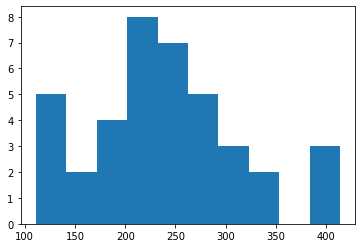

In [12]:
#@title Histogram of number of trials throughout the sessions
# Histogram of number of trials throughout the sessions
plt.hist(n_trials_session)
print(n_trials_session.mean())

In [13]:
# Select one session
i_session_max_trials = np.argmax(n_trials_session)
print(i_session_max_trials, n_trials_session[i_session_max_trials])

9 414.0


We'll focus on the session i_session_max_trials, which has the most trials and analyze the activity in the brain areas recorded during this session to try to predict the mouse's response during the trials.

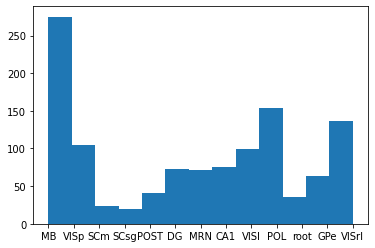

275

In [14]:
#@title Histogram of num of neurons per brain area for the selected session 
plt.hist(filtered_data[i_session_max_trials]['brain_area'],bins=13)
plt.show()
np.count_nonzero(filtered_data[i_session_max_trials]['brain_area']=='MB')

## Helper functions for retrieving data

In [15]:
def get_outcomes_action_with_session(session_data):
  response = session_data['response']
  is_action = response != 0
  return is_action.astype(int)

In [16]:
def get_outcomes_correct_with_session(session_data):
  response = session_data['response'] # right - nogo - left (-1, 0, 1)
  vis_right = session_data['contrast_right'] # 0 - low - high
  vis_left = session_data['contrast_left'] # 0 - low - high
  correct_response = np.sign(vis_left-vis_right) 
  is_correct = response == correct_response
  outcomes_correct = is_correct.astype(int)
  return outcomes_correct

In [17]:
# def get_choice_data_with_session(session_data):
#   is_choice_trial = session_data['response'] != 0
#   movement_onset = session_data['reaction_time'][is_choice_trial, 0]
#   session_data['spks'][:, is_choice_trial, :]
#   data = {
#       'spks',
#       'choice',
#       'brain_area'
#   }
  

In [18]:
#@title Retrieve correct (1) or incorrect (0) outcome
i_focus = i_session_max_trials
outcomes_correct = get_outcomes_correct_with_session(filtered_data[i_focus])
print(outcomes_correct.mean())

0.6376811594202898


In [19]:
def get_neurons_spikes_with_session_area_window(session_data, brain_area, window):
  is_brain_area = session_data['brain_area'] == brain_area
  return session_data['spks'][is_brain_area, :, window]

In [20]:
#filtered_data_focus is not define
# focus_brain_area='MB'
# spikes_focus = get_neurons_spikes_with_session_area_window(filtered_data_focus, focus_brain_area, slice(0, 250, 1))


## Helper functions for decoding

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [22]:
def compute_single_neuron_decoding_accuracies(spikes_per_neuron, outcomes, penalty='none', scoring=None):
  n_neurons = spikes_per_neuron.shape[0]
  n_trials = spikes_per_neuron.shape[1]
  # average over time
  spikes_per_neuron_time_avg = spikes_per_neuron.mean(axis=2)
  decoding_accuracies = np.empty(n_neurons)
  decoding_accuracies_chance = np.empty(n_neurons)
  for i_neuron in range(n_neurons):
    X = spikes_per_neuron_time_avg[i_neuron, :][:, None]
    decoding_accuracies[i_neuron] = cross_val_score(LogisticRegression(penalty=penalty), X, outcomes, scoring=scoring, cv=8, n_jobs=-1).mean()
    # shuffle trials to get chance level
    X = X.copy()
    np.random.shuffle(X)
    decoding_accuracies_chance[i_neuron] = cross_val_score(LogisticRegression(penalty=penalty), X, outcomes, scoring=scoring, cv=8, n_jobs=-1).mean() # k=8 crossvalidation
  return decoding_accuracies, decoding_accuracies_chance

In [23]:
def compute_all_neuron_decoding_accuracies(spikes_per_neuron, outcomes, penalty='none', scoring=None):#"l2"
  n_neurons = spikes_per_neuron.shape[0]
  n_trials = spikes_per_neuron.shape[1]
  # average over time
  spikes_all_neuron_time_avg = spikes_per_neuron.mean(axis=2)
  decoding_accuracies = 0
  decoding_accuracies_chance = 0
  X = spikes_all_neuron_time_avg.T
  decoding_accuracies = cross_val_score(LogisticRegression(penalty=penalty), X, outcomes, scoring=scoring, cv=8, n_jobs=-1).mean()
  # shuffle trials to get chance level
  X = X.copy()
  np.random.shuffle(X)
  decoding_accuracies_chance = cross_val_score(LogisticRegression(penalty=penalty), X, outcomes, scoring=scoring, cv=8, n_jobs=-1).mean() # k=8 crossvalidation
  return decoding_accuracies, decoding_accuracies_chance

In [27]:
import math
def get_rectangular_sliding_windows(t_min, t_max, window_duration, bin_duration):
  window_width = round(window_duration / bin_duration)
  i_min, i_max = math.ceil(t_min / bin_duration), math.floor(t_max / bin_duration)
  i_start_range = range(i_min, i_max + 1 - window_width)
  window_slices = [slice(i_start, i_start + window_width, 1) for i_start in i_start_range ]
  window_end_times = [ i_start * bin_duration + window_duration for i_start in i_start_range ]
  return window_slices, window_end_times

print(bin_size)
window_slices, window_end_times = get_rectangular_sliding_windows(0, 2.5, 0.05, bin_size)
print(window_slices)
print(window_end_times)

0.01
[slice(0, 5, 1), slice(1, 6, 1), slice(2, 7, 1), slice(3, 8, 1), slice(4, 9, 1), slice(5, 10, 1), slice(6, 11, 1), slice(7, 12, 1), slice(8, 13, 1), slice(9, 14, 1), slice(10, 15, 1), slice(11, 16, 1), slice(12, 17, 1), slice(13, 18, 1), slice(14, 19, 1), slice(15, 20, 1), slice(16, 21, 1), slice(17, 22, 1), slice(18, 23, 1), slice(19, 24, 1), slice(20, 25, 1), slice(21, 26, 1), slice(22, 27, 1), slice(23, 28, 1), slice(24, 29, 1), slice(25, 30, 1), slice(26, 31, 1), slice(27, 32, 1), slice(28, 33, 1), slice(29, 34, 1), slice(30, 35, 1), slice(31, 36, 1), slice(32, 37, 1), slice(33, 38, 1), slice(34, 39, 1), slice(35, 40, 1), slice(36, 41, 1), slice(37, 42, 1), slice(38, 43, 1), slice(39, 44, 1), slice(40, 45, 1), slice(41, 46, 1), slice(42, 47, 1), slice(43, 48, 1), slice(44, 49, 1), slice(45, 50, 1), slice(46, 51, 1), slice(47, 52, 1), slice(48, 53, 1), slice(49, 54, 1), slice(50, 55, 1), slice(51, 56, 1), slice(52, 57, 1), slice(53, 58, 1), slice(54, 59, 1), slice(55, 60, 1), s

### Dimensionality reduction

In [26]:
from sklearn.decomposition import PCA

def principal_component_features_from_spikes_per_neuron(spikes_per_neuron, n_components=5):
  n_neurons = spikes_per_neuron.shape[0]
  n_trials = spikes_per_neuron.shape[1]
  n_time_steps = spikes_per_neuron.shape[2] if len(spikes_per_neuron.shape) > 2 else 1
  X = spikes_per_neuron.reshape((n_neurons, n_trials * n_time_steps)).T
  pca_model = PCA(n_components=min(n_components, X.shape[1]), copy=True)
  X_pca = pca_model.fit_transform(X)
  return X_pca, pca_model


In [27]:
def compute_principal_component_decoding_accuracies(spikes_per_neuron, outcomes, penalty='none', n_components=5, scoring=None):
  n_neurons = spikes_per_neuron.shape[0]
  n_trials = spikes_per_neuron.shape[1]
  # average over time
  spikes_per_neuron_time_avg = spikes_per_neuron.mean(axis=2)
  # reduce dimensionality
  X, pca_model = principal_component_features_from_spikes_per_neuron(spikes_per_neuron_time_avg)
  # print("pca explained_variance_ratios", pca_model.explained_variance_ratio_)
  # print("pca explained_variance_ratios total", np.sum(pca_model.explained_variance_ratio_))
  # compute decoding accuracy
  decoding_accuracy = cross_val_score(LogisticRegression(penalty=penalty), X, outcomes, scoring=scoring, cv=8, n_jobs=-1).mean()
  # shuffle trials to get chance level
  X = X.copy()
  np.random.shuffle(X)
  decoding_accuracy_chance = cross_val_score(LogisticRegression(penalty=penalty), X, outcomes, scoring=scoring, cv=8, n_jobs=-1).mean() # k=8 crossvalidation
  return decoding_accuracy, decoding_accuracy_chance

## Decode action from all neurons per brain area, using the avg firing rate over a small sliding window

In [43]:
i_session = 7
thresh_print = 0.15
penalty = 'l2'
scoring = 'roc_auc'
window_size = .050 # s
t_min, t_max = 0., 2.5 #s
filtered_data_focus = filtered_data[i_session]
outcomes_action = get_outcomes_action_with_session(filtered_data_focus)
brain_areas = set(filtered_data_focus['brain_area'])
window_slices, window_end_times = get_rectangular_sliding_windows(0, 2.5, 0.05, bin_size)
n_slices = len(window_slices)
decoding_accuracies_by_brain_area = { brain_area: np.zeros(n_slices) for brain_area in brain_areas }
for brain_area in brain_areas:
  print("decoding on brain_area", brain_area)
  decoding_accuracies = decoding_accuracies_by_brain_area[brain_area]
  for i_window, window_slice in enumerate(window_slices):
    spikes_per_neuron = get_neurons_spikes_with_session_area_window(filtered_data_focus, brain_area, window_slice)
    decoding_accuracy, decoding_accuracy_chance = \
      compute_all_neuron_decoding_accuracies(spikes_per_neuron, outcomes_action,
                                             penalty=penalty, scoring=scoring)
    decoding_accuracies[i_window] = decoding_accuracy
    # decoding_accuracy_diff = decoding_accuracy - decoding_accuracy_chance
    # if decoding_accuracy_diff > thresh_print:
    #   print("found!")
    #   print(f"decoding {scoring} {decoding_accuracy:.2f}, chance {scoring}: {decoding_accuracy_chance:.2f}, difference {scoring}: {decoding_accuracy_diff:.2f}")

decoding on brain_area PO
decoding on brain_area VISp
decoding on brain_area CA3
decoding on brain_area LD
decoding on brain_area root
decoding on brain_area PL
decoding on brain_area LSr
decoding on brain_area DG
decoding on brain_area SUB
decoding on brain_area VISa
decoding on brain_area MOs
decoding on brain_area TT
decoding on brain_area LP
decoding on brain_area ILA
decoding on brain_area CA1


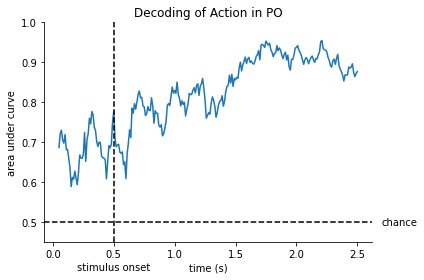

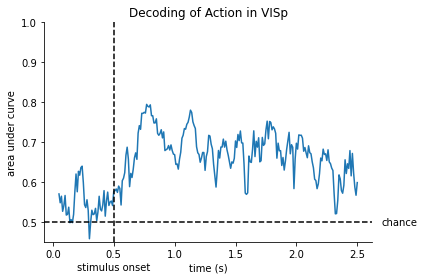

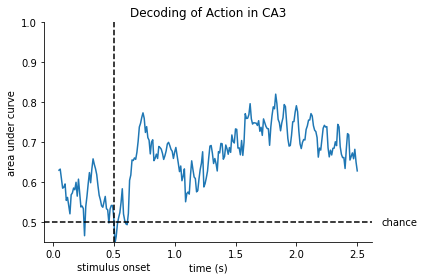

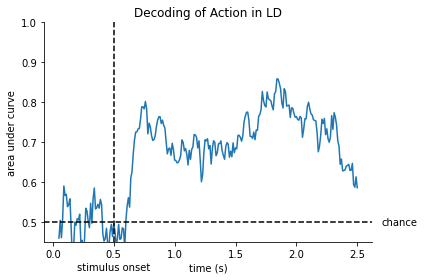

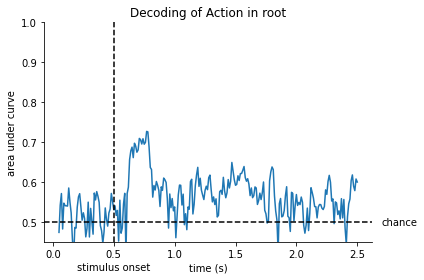

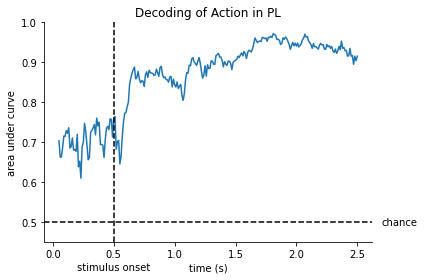

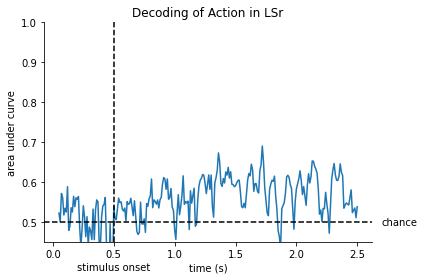

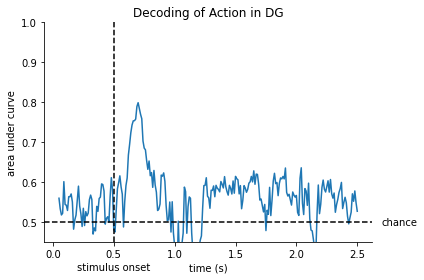

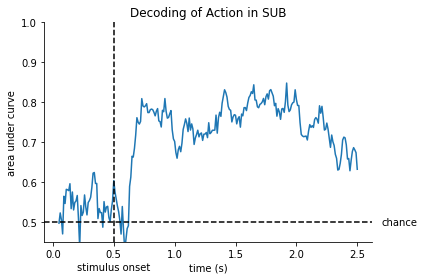

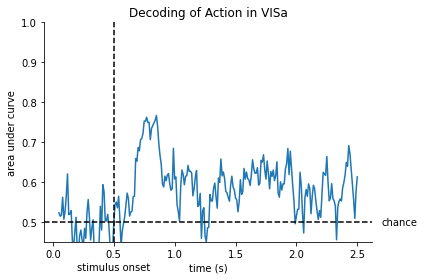

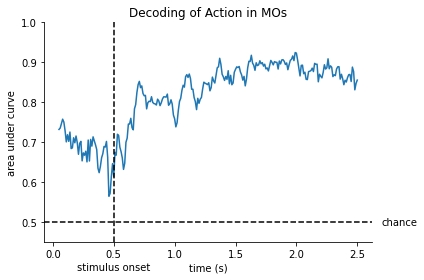

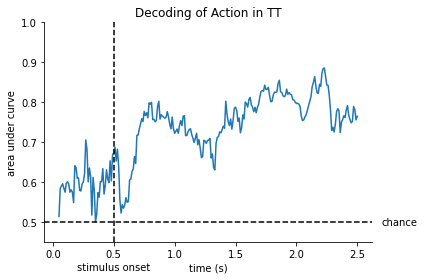

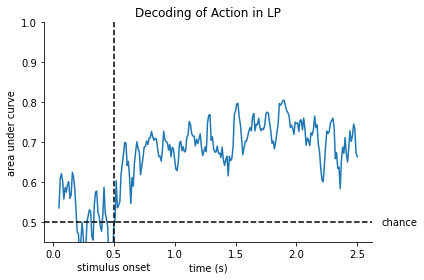

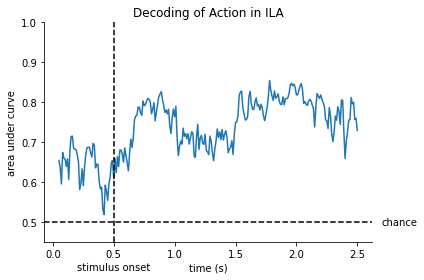

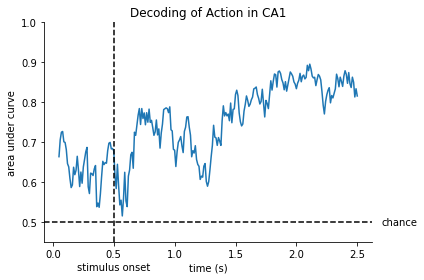

In [45]:
stim_onset = 0.5
for brain_area, decoding_accuracies in decoding_accuracies_by_brain_area.items():
  fig = plt.figure()
  ax = fig.gca()
  plt.plot(window_end_times, decoding_accuracies)
  plt.xlabel("time (s)")
  plt.ylabel("area under curve")
  plt.axhline(y=0.5, ls='--', c='k')
  plt.axvline(x=stim_onset, ls='--', c='k')
  plt.text(window_end_times[-1] + 0.2, 0.5, "chance", va='center', ha='left')
  plt.text(stim_onset, 0.4, "stimulus onset", va='top', ha='center')
  plt.title(f"Decoding of Action in {brain_area}")
  plt.ylim(0.45, 1.)

## Decode from all the neurons on each possible brain area and sessions

In [ ]:
window = slice(0, 50, 1)
# window = slice(30, 50, 1)
thresh_print = 0.04
for i_session in range(n_sessions):
  print("session", i_session)
  filtered_data_focus = filtered_data[i_session]
  outcomes_correct = get_outcomes_correct_with_session(filtered_data_focus)
  correct_score_mouse=np.count_nonzero(outcomes_correct)/len(outcomes_correct)
  brain_areas = set(filtered_data_focus['brain_area'])
  for brain_area in brain_areas:
    print("decoding on brain_area", brain_area)
    spikes_per_neuron = get_neurons_spikes_with_session_area_window(filtered_data_focus, brain_area, window) #  spikes_per_neuron.shape == (neurons*trials*time) 
    decoding_accuracies, decoding_accuracies_chance = compute_all_neuron_decoding_accuracies(spikes_per_neuron, outcomes_correct)
    decoding_accuracies_diff = decoding_accuracies - decoding_accuracies_chance
    if np.any(decoding_accuracies_diff > thresh_print):
      print("found!")
      # print("decoding_accuracies", decoding_accuracies)
      # print("decoding_accuracies_chance", decoding_accuracies_chance)
      print("max diff: ", (decoding_accuracies_diff).max())
      print("decoding_accuracies :",decoding_accuracies)
      print("correct_score_mouse :", correct_score_mouse,"incorrect_score_mouse :", 1-correct_score_mouse)
      #plt.figure()
      #plt.hist(decoding_accuracies_diff)
      #plt.show()

session 0
decoding on brain_area DG
decoding on brain_area LS
decoding on brain_area SUB
decoding on brain_area CA3
decoding on brain_area MOs
decoding on brain_area root
decoding on brain_area ACA
decoding on brain_area VISp
session 1
decoding on brain_area POST
decoding on brain_area VISl
decoding on brain_area CA1
found!
max diff:  0.062038177339901523
decoding_accuracies : 0.5224753694581281
correct_score_mouse : 0.6521739130434783 incorrect_score_mouse : 0.34782608695652173
decoding on brain_area VISpm
decoding on brain_area root
session 2
decoding on brain_area NB
decoding on brain_area DG
decoding on brain_area POST
found!
max diff:  0.10230769230769221
decoding_accuracies : 0.6507692307692308
correct_score_mouse : 0.6747572815533981 incorrect_score_mouse : 0.3252427184466019
decoding on brain_area SPF
decoding on brain_area CA1
found!
max diff:  0.0921153846153846
decoding_accuracies : 0.6111538461538462
correct_score_mouse : 0.6747572815533981 incorrect_score_mouse : 0.3252427

## Decode from principal components over the neurons (averaged over prestimulus period) on each possible brain area and sessions

In [35]:
np.random.seed(35)
window = slice(0, 50, 1)
thresh_print = 0.06
n_components = .9
penalty = 'none'
scoring = 'roc_auc'
for i_session in range(n_sessions):
  filtered_data_focus = filtered_data[i_session]
  outcomes_correct = get_outcomes_correct_with_session(filtered_data_focus)
  print(f"session {i_session}, mouse accuracy:{outcomes_correct.mean() * 100:.1f} %")
  brain_areas = set(filtered_data_focus['brain_area'])
  for brain_area in brain_areas:
    spikes_per_neuron = get_neurons_spikes_with_session_area_window(filtered_data_focus, brain_area, window)
    decoding_accuracy, decoding_accuracy_chance = \
      compute_principal_component_decoding_accuracies(spikes_per_neuron, outcomes_correct,
                                                      n_components=n_components, penalty=penalty, scoring=scoring)
    decoding_accuracy_diff = decoding_accuracy - decoding_accuracy_chance
    if decoding_accuracy_diff > thresh_print:
      print("found!")
      print("brain_area", brain_area)
      print(f"decoding {scoring} {decoding_accuracy:.2f}, chance {scoring}: {decoding_accuracy_chance:.2f}, difference {scoring}: {decoding_accuracy_diff:.2f}")

session 0, mouse accuracy:67.8 %
found!
brain_area root
decoding roc_auc 0.61, chance roc_auc: 0.50, difference roc_auc: 0.11
found!
brain_area LS
decoding roc_auc 0.72, chance roc_auc: 0.48, difference roc_auc: 0.25
found!
brain_area MOs
decoding roc_auc 0.63, chance roc_auc: 0.54, difference roc_auc: 0.09
found!
brain_area VISp
decoding roc_auc 0.55, chance roc_auc: 0.43, difference roc_auc: 0.12
found!
brain_area CA3
decoding roc_auc 0.59, chance roc_auc: 0.47, difference roc_auc: 0.12
session 1, mouse accuracy:65.2 %
found!
brain_area root
decoding roc_auc 0.58, chance roc_auc: 0.49, difference roc_auc: 0.09
found!
brain_area VISl
decoding roc_auc 0.62, chance roc_auc: 0.41, difference roc_auc: 0.21
found!
brain_area CA1
decoding roc_auc 0.66, chance roc_auc: 0.50, difference roc_auc: 0.16
session 2, mouse accuracy:67.5 %
found!
brain_area VISam
decoding roc_auc 0.52, chance roc_auc: 0.44, difference roc_auc: 0.07
found!
brain_area POST
decoding roc_auc 0.58, chance roc_auc: 0.48, 

## Decode from each individual neuron on each possible brain area and sessions

Ideas to do next:
- try with all the neurons (keeping time average). try L1, L2 regularization, or elasticnet.
-- feedback period
-- prestimulus period
- try with kernel (e.g. polynomial degree 2-3, gaussian)
- try with principal component over the neurons (PCA) # decoding from PCA ~= L2 regularization? <ref needed>
- try to not average over time. each time step = 1 feature. 
- try to decode at the feedback period. or after the go cue. time-average and without.

session 0, mouse accuracy:67.8 %
session 1, mouse accuracy:65.2 %
session 2, mouse accuracy:67.5 %
session 3, mouse accuracy:69.0 %
session 4, mouse accuracy:67.0 %
session 5, mouse accuracy:75.5 %
session 6, mouse accuracy:67.4 %
session 7, mouse accuracy:65.8 %
found!
brain_area PL
max decoding accuracy from chance level: 9.9


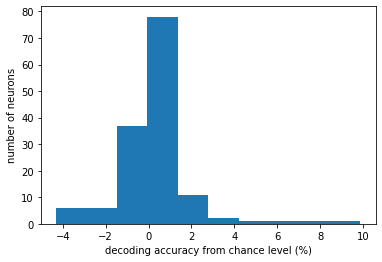

found!
brain_area MOs
max decoding accuracy from chance level: 6.5


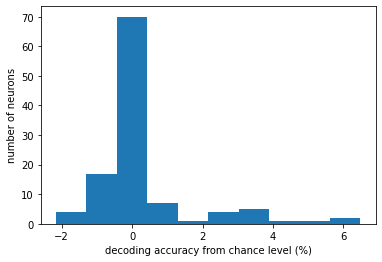

session 8, mouse accuracy:70.7 %
session 9, mouse accuracy:63.8 %
session 10, mouse accuracy:82.0 %
session 11, mouse accuracy:73.3 %
session 12, mouse accuracy:80.7 %
session 13, mouse accuracy:70.7 %
session 14, mouse accuracy:77.3 %
session 15, mouse accuracy:72.7 %
session 16, mouse accuracy:84.0 %
session 17, mouse accuracy:79.5 %
session 18, mouse accuracy:61.3 %
found!
brain_area DG
max decoding accuracy from chance level: 6.3


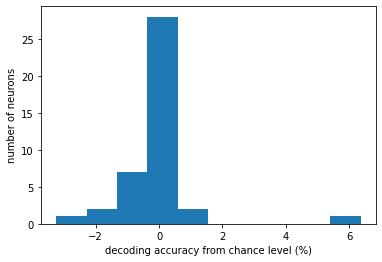

found!
brain_area root
max decoding accuracy from chance level: 6.9


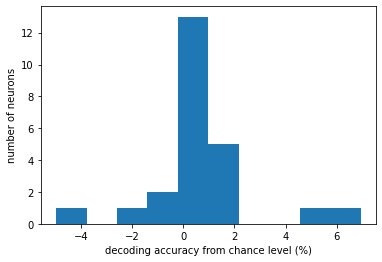

session 19, mouse accuracy:63.4 %
session 20, mouse accuracy:56.8 %
found!
brain_area SSp
max decoding accuracy from chance level: 16.3


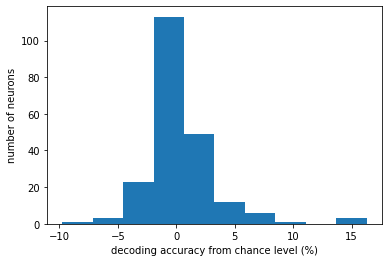

found!
brain_area VAL
max decoding accuracy from chance level: 12.0


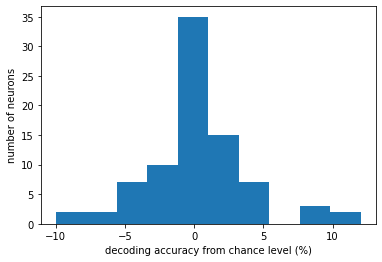

found!
brain_area LD
max decoding accuracy from chance level: 12.6


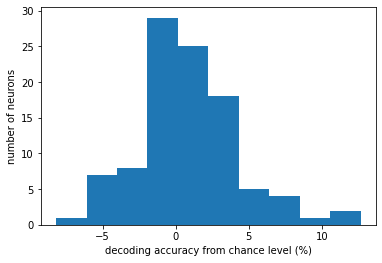

found!
brain_area MOp
max decoding accuracy from chance level: 7.3


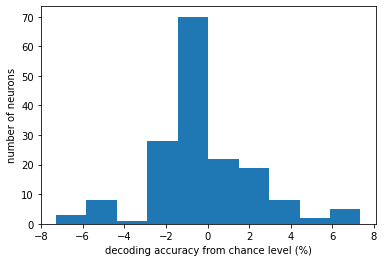

session 21, mouse accuracy:71.6 %
session 22, mouse accuracy:69.3 %
found!
brain_area CA1
max decoding accuracy from chance level: 5.8


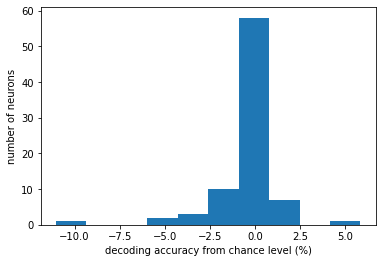

found!
brain_area root
max decoding accuracy from chance level: 7.4


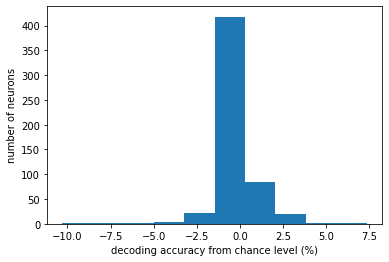

session 23, mouse accuracy:58.7 %
found!
brain_area SCig
max decoding accuracy from chance level: 5.9


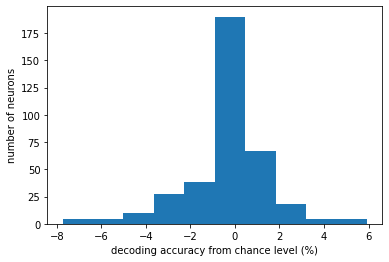

found!
brain_area CA2
max decoding accuracy from chance level: 7.0


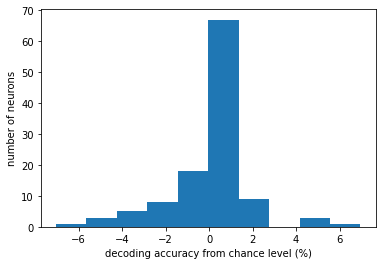

found!
brain_area CA1
max decoding accuracy from chance level: 5.2


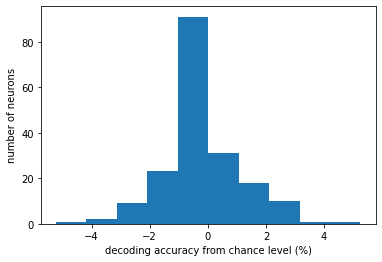

found!
brain_area RSP
max decoding accuracy from chance level: 7.0


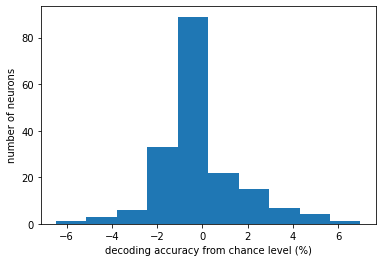

found!
brain_area VISpm
max decoding accuracy from chance level: 8.9


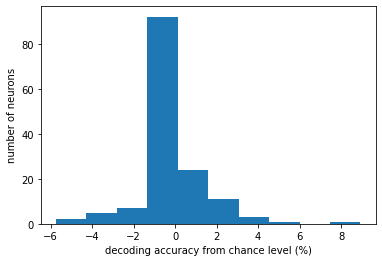

found!
brain_area MRN
max decoding accuracy from chance level: 7.7


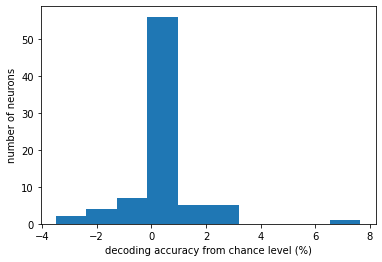

session 24, mouse accuracy:75.9 %
session 25, mouse accuracy:75.9 %
found!
brain_area MOs
max decoding accuracy from chance level: 6.2


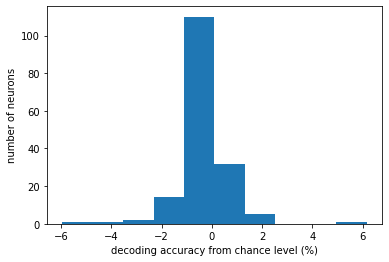

session 26, mouse accuracy:66.5 %
session 27, mouse accuracy:60.6 %
found!
brain_area SCig
max decoding accuracy from chance level: 5.1


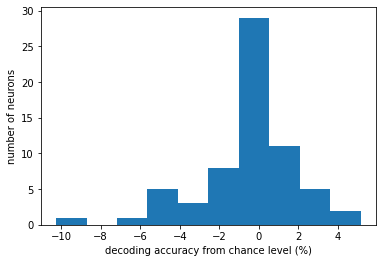

found!
brain_area CA1
max decoding accuracy from chance level: 5.9


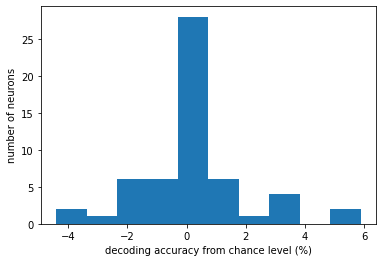

found!
brain_area RSP
max decoding accuracy from chance level: 7.4


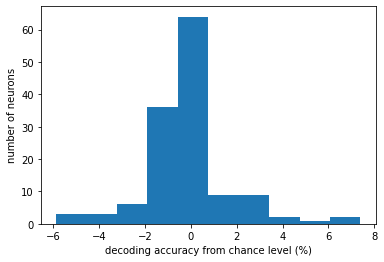

found!
brain_area MRN
max decoding accuracy from chance level: 5.1


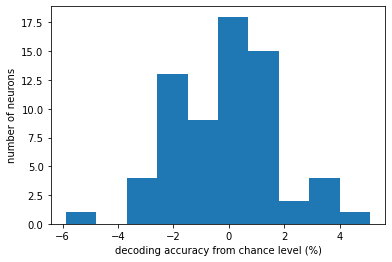

session 28, mouse accuracy:61.4 %
found!
brain_area CP
max decoding accuracy from chance level: 7.1


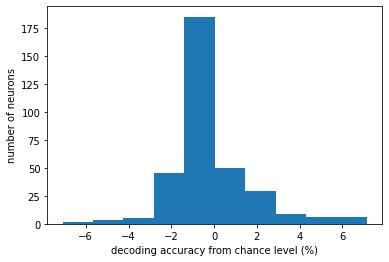

found!
brain_area SSp
max decoding accuracy from chance level: 8.9


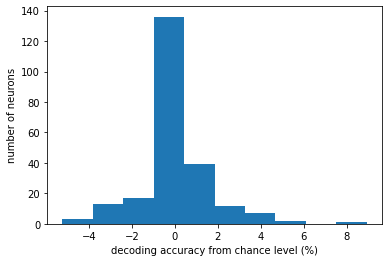

found!
brain_area MOp
max decoding accuracy from chance level: 12.4


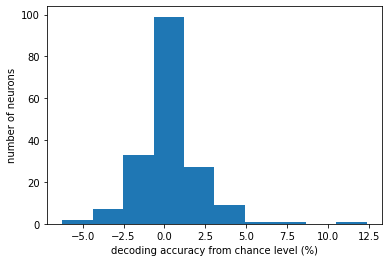

session 29, mouse accuracy:51.1 %
found!
brain_area DG
max decoding accuracy from chance level: 16.2


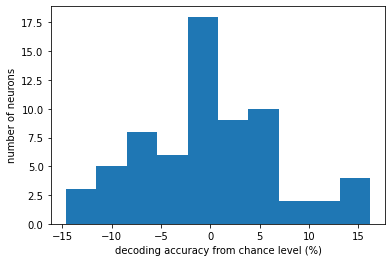

found!
brain_area VISa
max decoding accuracy from chance level: 11.7


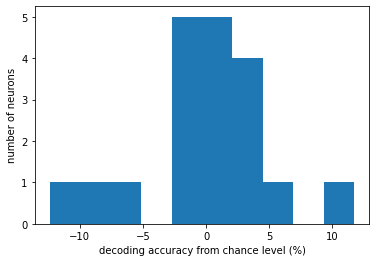

found!
brain_area CL
max decoding accuracy from chance level: 17.1


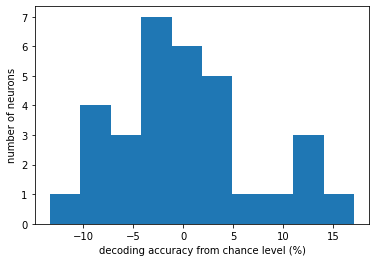

found!
brain_area LS
max decoding accuracy from chance level: 12.5


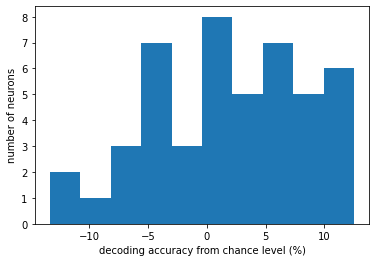

found!
brain_area SUB
max decoding accuracy from chance level: 16.2


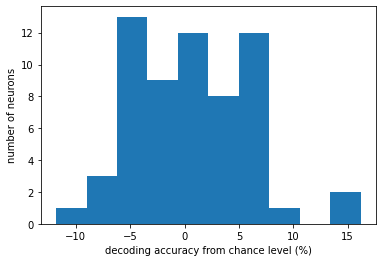

found!
brain_area PO
max decoding accuracy from chance level: 24.3


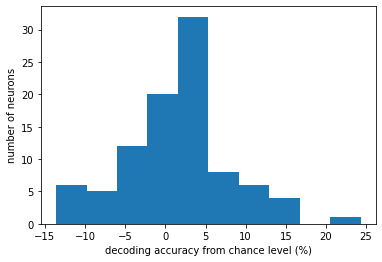

found!
brain_area MD
max decoding accuracy from chance level: 20.0


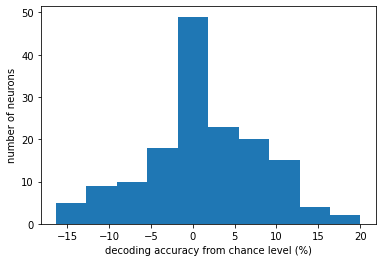

found!
brain_area CA1
max decoding accuracy from chance level: 12.3


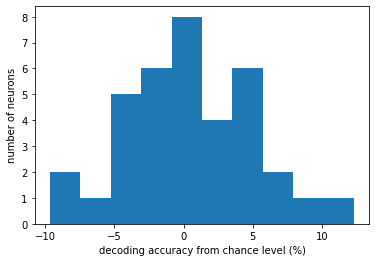

found!
brain_area RSP
max decoding accuracy from chance level: 15.6


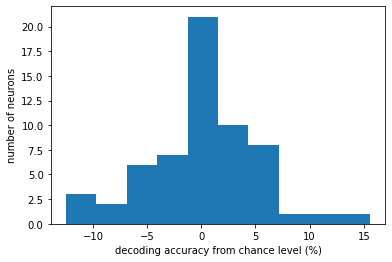

found!
brain_area MOs
max decoding accuracy from chance level: 13.1


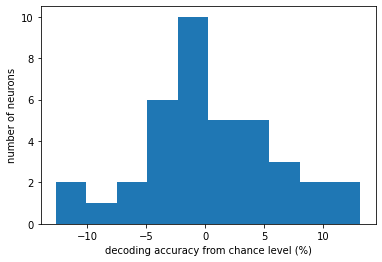

found!
brain_area root
max decoding accuracy from chance level: 17.3


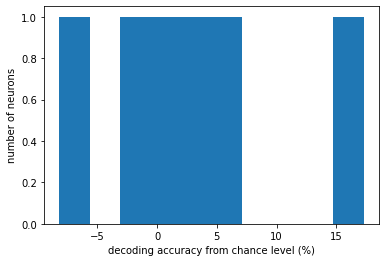

found!
brain_area LP
max decoding accuracy from chance level: 13.4


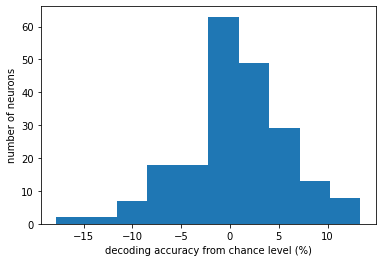

found!
brain_area VPM
max decoding accuracy from chance level: 27.3


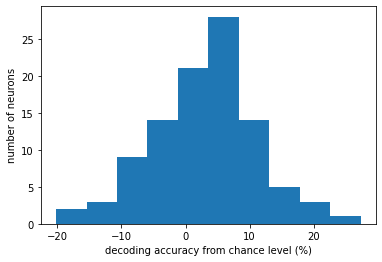

session 30, mouse accuracy:72.8 %
session 31, mouse accuracy:72.5 %
session 32, mouse accuracy:69.4 %
found!
brain_area CP
max decoding accuracy from chance level: 5.5


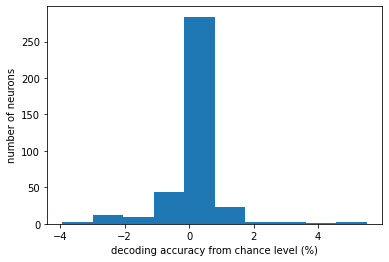

session 33, mouse accuracy:60.6 %
session 34, mouse accuracy:79.4 %
session 35, mouse accuracy:75.8 %
session 36, mouse accuracy:76.6 %
found!
brain_area MB
max decoding accuracy from chance level: 6.0


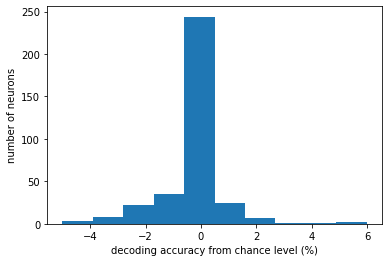

session 37, mouse accuracy:66.7 %
session 38, mouse accuracy:71.7 %


In [ ]:
window = slice(0, 50, 1)
# window = slice(30, 50, 1)
thresh_print = 0.05
for i_session in range(n_sessions):
  filtered_data_focus = filtered_data[i_session]
  outcomes_correct = get_outcomes_correct_with_session(filtered_data_focus)
  print(f"session {i_session}, mouse accuracy:{outcomes_correct.mean() * 100:.1f} %")
  brain_areas = set(filtered_data_focus['brain_area'])
  for brain_area in brain_areas:
    spikes_per_neuron = get_neurons_spikes_with_session_area_window(filtered_data_focus, brain_area, window)
    decoding_accuracies, decoding_accuracies_chance = compute_single_neuron_decoding_accuracies(spikes_per_neuron, outcomes_correct)
    decoding_accuracies_diff = decoding_accuracies - decoding_accuracies_chance
    if np.any(decoding_accuracies_diff > thresh_print):
      print("found!")
      print("brain_area", brain_area)
      print(f"max decoding accuracy from chance level: {decoding_accuracies_diff.max()*100:.1f}%")
      plt.figure()
      plt.hist(decoding_accuracies_diff*100)
      plt.xlabel("decoding accuracy from chance level (%)")
      plt.ylabel("number of neurons")
      plt.show()

## Fitting the model manually

In [ ]:
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.
  
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.  
  """


  y_pred = model.predict(X)

  accuracy = np.count_nonzero(y_pred==y)/len(y)

  return accuracy

avg_spikes=spikes_focus.mean(axis=0)
print(avg_spikes.shape)
# outcomes_correct=>label 0 or 1
y = outcomes_correct
X = avg_spikes

# First define the model
log_reg = LogisticRegression(penalty="none")
#Then fit it to data
log_reg.fit(X, y)
y_pred = log_reg.predict(X)

train_accuracy = compute_accuracy(X, y, log_reg)
print(f"Accuracy on the training data averaging over all neurons considering the whole time period: {train_accuracy:.2%}")

In [ ]:
X = avg_spikes[:, 0:50]
log_reg = LogisticRegression(penalty="none")
log_reg.fit(X, y)
y_pred = log_reg.predict(X)

train_accuracy = compute_accuracy(X, y, log_reg)

print(f"Accuracy on the training data averaging over all neurons considering the prestimulus period: {train_accuracy:.2%}")

In [ ]:
# X = spikes_focus[24, :, 0:50]
# log_reg = LogisticRegression(penalty="none")
# log_reg.fit(X, y)
# y_pred = log_reg.predict(X)

# train_accuracy = compute_accuracy(X, y, log_reg)

# print(f"Accuracy on the training data with a single neuron considering the prestimulus period: {train_accuracy:.2%}")

## Decode on average over the neurons and the prestimulus time zone

In [ ]:
avg_neurones_prestimulus=spikes_focus[:,:,:50].mean(axis=2)
y = outcomes_correct
X = avg_neurones_prestimulus.T
scores = cross_val_score(LogisticRegression(penalty='l2'), X, y, cv=8) # k=8 crossvalidation
scores.mean()

In [ ]:
X_random=avg_neurones_prestimulus.T.copy()
np.random.shuffle(X_random)
chance_decoding_accuracy = cross_val_score(LogisticRegression(penalty='l2'),X_random, y, cv=8).mean() # k=8 crossvalidation
chance_decoding_accuracy

In [ ]:
print("X.shape", X.shape)

In [ ]:
# Iterate over single neurons
n_neurons = avg_neurones_prestimulus.shape[0]
mean_decoding_accuracies = np.empty(n_neurons)
for i_neuron in range(n_neurons):
  X = avg_neurones_prestimulus[i_neuron, :][:, None]
  mean_decoding_accuracies[i_neuron] = cross_val_score(LogisticRegression(penalty='none'), X, y, cv=8).mean()
plt.hist(mean_decoding_accuracies)
print(mean_decoding_accuracies)
print(mean_decoding_accuracies.max())

## Decode from all the neurons, over the prestimulus time zone

In [ ]:
#(275, 414, 250) =>(414,275*250)
X_all=[]

y = outcomes_correct

for i in range(len(spikes_focus[:,:,:50][0])):
  all_neuron_over_time_by_trial=[]
  for j in range(len(spikes_focus[:,:,:50])):
    
    for k in spikes_focus[:,:,:50][j][i]:
      all_neuron_over_time_by_trial.append(k)
  X_all.append(all_neuron_over_time_by_trial)

X_all=np.array(X_all)
X_all.shape

In [ ]:
cross_val_score(LogisticRegression(penalty='l2'), X_all, y, cv=8) # k=8 crossvalidation

# look for active neurons

In [ ]:
count=0
active_trial=np.zeros(len(spikes_focus))
for i in range(len(spikes_focus)):
  count=0
  for j in range(len(spikes_focus[0,:,0])):
    if spikes_focus[i,j,:].sum()<5:
      count+=1
  active_trial[i]=len(spikes_focus[0,:,0])-count
  #print(count,'/',j+1)
print(np.count_nonzero(active_trial>20))

In [ ]:
#@title Show some spikes data
_=plt.eventplot(spikes_focus[20:30,2,:])
spikes_focus[25:26,2,:]